In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['koko-newdata', 'iwildcam-2019-fgvc6']


In [16]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.optimizers import SGD, Adam
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [17]:
x_train = np.load('../input/koko-newdata/X_newtrain.npy')
x_test = np.load('../input/koko-newdata/X_newtest.npy')
y_train = np.load('../input/koko-newdata/y_newtrain.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (98150, 32, 32, 3)
98150 train samples
9815 test samples


In [18]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [19]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

In [20]:
def create_Model():
    classifier=Sequential()
    classifier.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=x_train.shape[1:],activation='relu'))
    #classifier.add(Conv2D(64, (3, 3), activation='relu'))
    #classifier.add(ZeroPadding2D(padding=(1,1)))
    #classifier.add(BatchNormalization())
    #classifier.add(PReLU())
    classifier.add(Conv2D(32, (3, 3)))
    classifier.add(Activation('relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(64, (3, 3), padding='same'))
    classifier.add(Activation('relu'))
    classifier.add(Conv2D(64, (3, 3)))
    classifier.add(Activation('relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Flatten())
    classifier.add(Dense(256))
    classifier.add(Activation('relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(14))
    classifier.add(Activation('softmax'))
    return classifier
model=create_Model()
#opt = keras.optimizers.rmsprop(lr=0.0004, decay=1e-6)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_17 (Activation)   (None, 15, 15, 64)        0         
__________

In [21]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
# 64,7,0.1
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=3,
    callbacks=[checkpoint, f1_metrics],
    validation_split=0.1
)

Train on 88335 samples, validate on 9815 samples
Epoch 1/3
88335/88335 [==============================] - 285s 3ms/step - loss: 1.1101 - acc: 0.6900 - val_loss: 0.9097 - val_acc: 0.7183

Epoch 00001: val_acc improved from -inf to 0.71829, saving model to model.h5
val_f1: 0.1451 — val_precision: 0.2453 — val_recall: 0.1779
Epoch 2/3
   32/88335 [..............................] - ETA: 4:49 - loss: 0.3931 - acc: 0.9375

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


88335/88335 [==============================] - 285s 3ms/step - loss: 0.9103 - acc: 0.7176 - val_loss: 0.8076 - val_acc: 0.7529

Epoch 00002: val_acc improved from 0.71829 to 0.75293, saving model to model.h5
val_f1: 0.2550 — val_precision: 0.3234 — val_recall: 0.2668
Epoch 3/3
88335/88335 [==============================] - 282s 3ms/step - loss: 0.8287 - acc: 0.7386 - val_loss: 0.7326 - val_acc: 0.7682

Epoch 00003: val_acc improved from 0.75293 to 0.76821, saving model to model.h5
val_f1: 0.3015 — val_precision: 0.3879 — val_recall: 0.2911


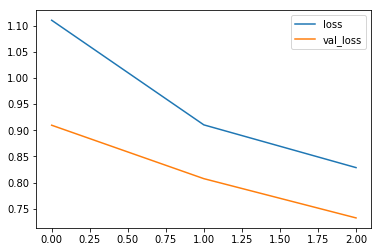

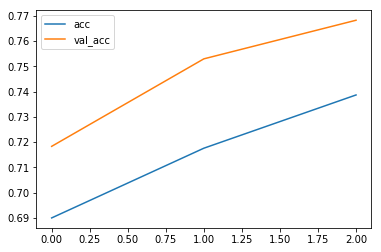

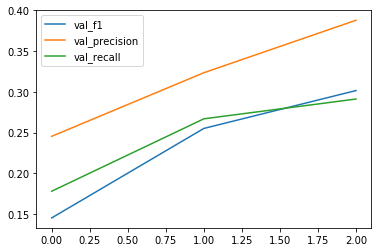

In [22]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

In [24]:
model.load_weights('model.h5')
y_train=np.load('../input/koko-newdata/y_coltrain.npy')
y_predict = model.predict(x_train)
y_predict=y_predict.argmax(axis=1)

In [25]:
y_train

array([18,  0,  0, ...,  0,  0, 11])

In [26]:
y_predict

array([6, 0, 0, ..., 0, 0, 6])

In [27]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score 
from sklearn.metrics import recall_score,precision_score,classification_report 
print('Accuracy:', accuracy_score(y_train, y_predict))
print('F1 score:', f1_score(y_train, y_predict,average='weighted'))
print('Recall:', recall_score(y_train, y_predict,
                              average='weighted'))
print('Precision:', precision_score(y_train, y_predict,
                                    average='weighted'))
print('\n clasification report:\n', classification_report(y_train, y_predict))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_predict))

Accuracy: 0.6515944982170148
F1 score: 0.6311046249991121
Recall: 0.6515944982170148
Precision: 0.619951165467038

 clasification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     65650
           1       0.84      0.38      0.52      3093
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00      1660
           4       0.00      0.00      0.00      1106
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00      3529
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00       529
          11       0.08      0.01      0.02      3577
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00      4286
          14       0.00      0.00      0.00       689
          16       0.00      0.00      0.00      3

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning


 confussion matrix:
 [[62736    95   549    90   182   281   187     0    52    65   114  1299
      0     0     0     0     0     0     0]
 [ 1610  1173    61     2    66   122     6     0     8     7     9    29
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  452     0   882     0   112     7     0     0    13   123    68     3
      0     0     0     0     0     0     0]
 [  439    14     0   145     2    26   274     0     0     0     0   206
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 1494    16   340     1   690   188   158     0    84   137    48   373
      0     0     0     0     0     0     0]
 [    0     0     0     0 

In [29]:
y_test=np.load('../input/koko-newdata/y_coltest.npy')
y_predict_test = model.predict(x_test)
y_predict_test=y_predict_test.argmax(axis=1)

In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score 
from sklearn.metrics import recall_score,precision_score,classification_report 
print('Accuracy:', accuracy_score(y_test, y_predict_test))
print('F1 score:', f1_score(y_test, y_predict_test,average='weighted'))
print('Recall:', recall_score(y_test, y_predict_test,
                              average='weighted'))
print('Precision:', precision_score(y_test, y_predict_test,
                                    average='weighted'))
print('\n clasification report:\n', classification_report(y_test, y_predict_test))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_predict_test))

Accuracy: 0.6539989811512991
F1 score: 0.6322650330210252
Recall: 0.6539989811512991
Precision: 0.6209099305709768

 clasification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      6566
           1       0.83      0.38      0.52       343
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00       185
           4       0.00      0.00      0.00       104
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00       345
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        58
          11       0.09      0.01      0.02       370
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00       421
          14       0.00      0.00      0.00        58
          16       0.00      0.00      0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning

In [31]:
def hoeffding_bound(Ein,N,M,confidence):
   delta=1-confidence
   A=np.log(2*M/delta)
   bond=np.sqrt(A/(2*N))
   limit=Ein-bond
   return limit

In [32]:
limit=hoeffding_bound(0.6311046249991121,98150,1,0.95)
print(limit)

0.6267696451607212
